The second part of preprocessing consists of different steps that are repeated for each channel of both epileptic and non-epileptic groups. Firstly, the drift correction is calculated for each signal and subtracted from each data channel. Then, the Fast Fourier Trasform (FFT) of the signal was calculated and Butterworth bandpass and notch filters are applied. The inverse trasform is computed, and the preprocessed signal and the FFT are saved.  

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math
import csv
from scipy.optimize import curve_fit
from scipy.fft import fft
from scipy import signal
from scipy.signal import iirnotch, lfilter
from scipy.signal import butter, filtfilt
import os
import networkx as nx
from scipy import stats
from scipy.stats import pearsonr
from statsmodels.sandbox.stats.multicomp import multipletests
from scipy.signal import find_peaks
import statistics
from scipy.signal import peak_widths
from sklearn.metrics import mutual_info_score
import matplotlib.patches as mpatches
from scipy.signal import butter, lfilter
import glob

In [ ]:
#GRAPHICAL SETTINGS
sns.set_style('whitegrid') # darkgrid, white grid, dark, white and ticks
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=10)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=9)    # fontsize of the tick labels
plt.rc('ytick', labelsize=9)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rcParams['lines.linewidth'] = 0.5
plt.rc('font', size=13)          # controls default text sizes

In [ ]:
#COLONNA[i] indica i valori del iesimo file della cartella "columns" (dipende da quanti/quali file si mettono dentro la cartella, ogni file rappresenta una colonna)
#COLONNACSV è UN ARRAY CONTENTENTE COME ELEMENTI I VARI FILE CSV CON LE COLONNE DIVISE (è tipo il COLONNACSV[0] è la prima colonna con indici e label )
folder_path = 'preprodata'

# Lista per memorizzare gli array
colonna = []

# Lista per memorizzare i DataFrame
colonnacsv = []

# Leggi tutti i file nella cartella
filenames = sorted([f for f in os.listdir(folder_path) if f.endswith('.csv')], key=lambda x: int(x.split('_')[0]))

for filename in filenames:
    # Costruisci il percorso completo del file
    file_path = os.path.join(folder_path, filename)

    # Leggi il file CSV
    df = pd.read_csv(file_path)

    # Aggiungi il DataFrame alla lista
    colonnacsv.append(df*10**6)

    # Per ogni colonna nel DataFrame
    for col in df.columns:
        # Moltiplica i valori per 10^6
        array = df[col].values * 10**6

        # Salva l'array nella lista
        colonna.append(array)

Fs = 500.0
Ts = 1.0/Fs
t = np.arange(len(colonna[0])) / Fs

print(colonnacsv[0])
print(colonna[0])

                 J1
0        -98.827927
1       -100.195114
2        -99.023240
3        -96.874803
4        -91.503710
...             ...
1349995   -5.566227
1349996   -7.812320
1349997  -10.546695
1349998  -16.308412
1349999  -19.824036

[1350000 rows x 1 columns]
[ -98.82792712 -100.19511435  -99.02323958 ...  -10.54669455  -16.30841216
  -19.82403647]


In [ ]:
def calculate_fft(data):
    fs=500
    # Calcola la trasformata di Fourier
    Y = np.fft.rfft(data)

    # Calcola le frequenze associate
    fft_freq = np.fft.rfftfreq(len(data), d=1/fs)

    # Calcola le ampiezze
    fft_amp = np.abs(Y)

    return fft_freq, fft_amp


def notch_filter(dataset, target_freq, q, fs):
    w0 = target_freq / (fs / 2)

    # Crea il filtro notch
    b, a = iirnotch(w0, q)

    # Applica il filtro notch ai dati
    filtered_data = lfilter(b, a, dataset)

    # Calcola la trasformata di Fourier dei dati filtrati
    fft_f,fft_values = calculate_fft(filtered_data)
    return filtered_data,fft_values, fft_f

def calculate_width(fft_amp, peak_index):
    best_w= None
    interval1 = range(peak_index - 600, peak_index - 200)
    interval2 = range(peak_index + 200, peak_index + 600)
    interval = np.array(np.concatenate((interval1, interval2)))
    mean=np.mean(fft_amp[interval])
    threshold = np.max(fft_amp[interval]-mean)
    for w in np.arange(2,200,1):
        diff=np.max([fft_amp[peak_index - w]-mean,fft_amp[peak_index + w]-mean])
        if diff > threshold:
            best_w = w
    return best_w


def calculate_error2(fft,filtered_fft_data, peak_index, width):
    # Determina gli indici degli intervalli per la media di peak_amplitude
    interval_indices_left = range(peak_index - 1000, peak_index - 500)
    interval_indices_right = range(peak_index + 500, peak_index + 1000)
    # Determina gli indici dell'intorno di peak_index
    nearby_indices = range(peak_index - width, peak_index + width)
    mean_interval_left = np.mean([fft[i] for i in interval_indices_left])
    mean_interval_right = np.mean([fft[i] for i in interval_indices_right])
    # Calcola la media complessiva di peak_amplitude negli intervalli
    mean = (mean_interval_left + mean_interval_right) / 2
    error=np.sum((filtered_fft_data[nearby_indices]-mean)**2)
    return error


def linear(x, a, b):
    return a * x + b

# Funzione per salvare ogni array in un file CSV separato
def save_arrays_to_csv(arrays,file_name,folder):
    # Definisci il nome del file CSV
    csv_file_name = f'{folder}/{file_name}.csv'
    # Scrivi l'array in un file CSV
    with open(csv_file_name, 'w', newline='', encoding='utf-8') as file:
            writer = csv.writer(file)
            # Scrivi l'intestazione
            writer.writerow([file_name])
            # Scrivi il resto dei valori
            writer.writerows([[value] for value in arrays[0:]])

def butter_bandpass(lowcut, highcut, order=5):
    nyq = 0.5 * 500
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='bandpass')
    w, h = signal.freqs(b, a)
    return b, a

def inverse_trasform(data, lowcut, highcut, order=5):
    b, a = butter_bandpass(lowcut, highcut, order=order)
    y = lfilter(b, a, data)
    return y


In [ ]:
# Ottieni una lista di tutti i file nella cartella
# Leggi tutti i file nella cartella
file_names = sorted([f for f in os.listdir(folder_path) if f.endswith('.csv')], key=lambda x: int(x.split('_')[0]))

print(file_names)


# Inizializzo una lista vuota per memorizzare le etichette
labels = []

# Itero su ogni DataFrame in colonnacsv
for df in colonnacsv:
    labels.append(df.columns[0])

labels_array = np.array(labels)

print(labels_array)

print(len(colonna))
print(len(labels_array))

label_electrodes=['J','T','L','Y','M','Q','I','N','F','G','O','A','R','H','X','Z']

['0_J1.csv', '1_J2.csv', '2_J3.csv', '3_J4.csv', '4_J5.csv']
['J1' 'J2' 'J3' 'J4' 'J5']
5
5


In [ ]:
#DIVIDO CANALI EPI E NON EPI
# Leggi il file Excel
df = pd.read_csv('1420_010_reduced_channel_labels.csv')

# Converti il DataFrame in una matrice
matrice = df.values

print(matrice)

dizionario_originale = df.set_index(df.columns[0]).T.to_dict('list')
print(dizionario_originale)

# Creiamo due dizionari vuoti per ospitare le chiavi con valori 0 e 1
dizionario_0 = {}
dizionario_1 = {}

# Ora iteriamo attraverso il dizionario originale e dividiamo le chiavi
for chiave, valore in dizionario_originale.items():
    if 0 in dizionario_originale[chiave]:
        dizionario_0[chiave] = valore
    elif 1 in dizionario_originale[chiave]:
        dizionario_1[chiave] = valore


[['J1' 1]
 ['J2' 1]
 ['J3' 1]
 ['J4' 1]
 ['J5' 1]
 ['J14' 0]
 ['J15' 0]
 ['J16' 0]
 ['T1' 0]
 ['T2' 0]
 ['T3' 0]
 ['T4' 0]
 ['L1' 1]
 ['L2' 1]
 ['L3' 1]
 ['L4' 1]
 ['L5' 1]
 ['L6' 1]
 ['L7' 1]
 ['J17' 0]
 ['J18' 0]
 ['L8' 1]
 ['L9' 1]
 ['L10' 1]
 ['L11' 1]
 ['L12' 1]
 ['L13' 1]
 ['L14' 1]
 ['L15' 1]
 ['Y1' 0]
 ['M1' 1]
 ['M2' 1]
 ['M3' 1]
 ['M4' 1]
 ['M5' 1]
 ['M15' 0]
 ['M16' 0]
 ['M17' 0]
 ['Y5' 0]
 ['Y6' 0]
 ['Y7' 0]
 ['Y8' 0]
 ['Y9' 0]
 ['Y10' 0]
 ['Y11' 0]
 ['Y2' 0]
 ['Q1' 0]
 ['Q2' 0]
 ['Q3' 0]
 ['Q4' 0]
 ['Q5' 0]
 ['Q6' 0]
 ['Q7' 0]
 ['Q8' 0]
 ['Q9' 0]
 ['I1' 0]
 ['I2' 0]
 ['I3' 0]
 ['I7' 0]
 ['I8' 0]
 ['I9' 0]
 ['I10' 0]
 ['N1' 1]
 ['N2' 1]
 ['N3' 1]
 ['N4' 1]
 ['N5' 1]
 ['N6' 1]
 ['N10' 0]
 ['N11' 0]
 ['N12' 0]
 ['N13' 0]
 ['N14' 0]
 ['N15' 0]
 ['N16' 0]
 ['N17' 0]
 ['N18' 0]
 ['F1' 0]
 ['F2' 0]
 ['F3' 0]
 ['F6' 0]
 ['F7' 0]
 ['F8' 0]
 ['F9' 0]
 ['F10' 0]
 ['F11' 0]
 ['F12' 0]
 ['G1' 0]
 ['G2' 0]
 ['G3' 0]
 ['G4' 0]
 ['G10' 0]
 ['G11' 0]
 ['O1' 0]
 ['O2' 0]
 ['O3' 0]
 ['O4' 0]

In [ ]:
#LINEAR FIT OF ALL COLUMNS(CHANNELS)

a_values = []
b_values = []

for i in range(len(colonna)):
    # Prendi i dati della colonna
    y_data = colonna[i]
    x_data = np.arange(len(y_data))

    # Esegui il fit lineare
    popt, pcov = curve_fit(linear, x_data, y_data)

    # Aggiungi i parametri ottimizzati alle rispettive liste
    a_values.append(popt[0])
    b_values.append(popt[1])

# Converti le liste in array numpy
a_values = np.array(a_values)
b_values = np.array(b_values)

#DRIFT CORRECTION PER OGNI COLONNA
signal_driftcorr=[]
for i in range(len(colonna)):
    # Prendi i dati della colonna
    y_data = colonna[i]
    x_data = np.arange(len(y_data))
    y_fit = a_values[i]*x_data + b_values[i] #calcola il valore in volt a partire dai parametri dei fit
    diff=y_data-y_fit
    signal_driftcorr.append(diff)





CHANNEL J1


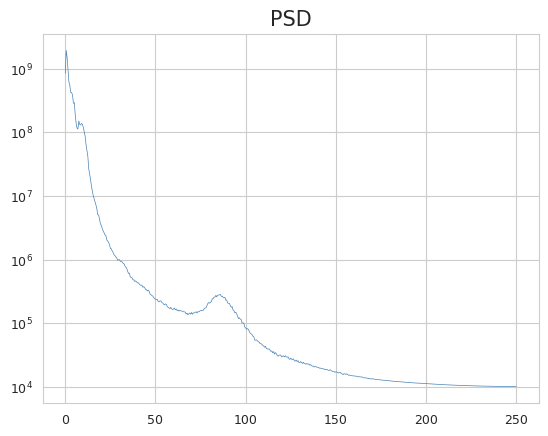

Ogni array è stato salvato
Ogni array è stato salvato
Ogni array è stato salvato
CHANNEL J2


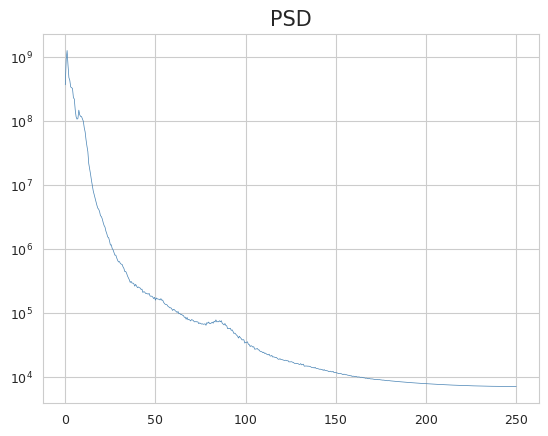

Ogni array è stato salvato
Ogni array è stato salvato
Ogni array è stato salvato
CHANNEL J3


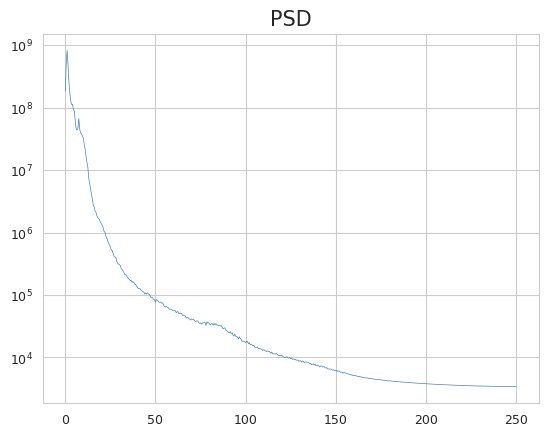

Ogni array è stato salvato
Ogni array è stato salvato
Ogni array è stato salvato
CHANNEL J4


KeyboardInterrupt: 

In [ ]:
label_array_0=[]
label_array_1=[]
bw_data=[]
for data, label_array in zip(signal_driftcorr, labels_array):
    Fs=500
    less_fft_freqs=[]
    less_fft_amps=[]
    less_data=[]
    fft_freqs,fft_vals=calculate_fft(data)
    best_Q_values=[]
    min_error_values=[]
    #TROVO IL MIGLIOR VALORE DI Q
    target_frequencies = [50, 100, 150]# Frequenze target per trovare i picchi
    if label_array in dizionario_0:
        label_array_0.append(label_array)
        colore='b'
        print('CHANNEL',label_array)
        for target_freq in target_frequencies:
            # Trova l'indice del picco più vicino alla frequenza target
            peak_index = np.argmin(np.abs(fft_freqs - target_freq))

            # Trova la larghezza del picco
            peak_width=calculate_width(fft_vals, peak_index)
            min_error = float('inf')  # Inizializza la minima differenza con un valore infinito
            best_Q = None  # Inizializza il miglior valore Q
            if peak_width is None:
                best_Q=None
            else:
                for Q in np.arange(10,6000,10):  # Itera su valori di Q
                    Q = round(Q, 4)
                    # Applica il filtro notch
                    filtered_data,filtered_fft,filtered_fft_freq = notch_filter(data, target_freq, Q, Fs)
                    er = calculate_error2(fft_vals,filtered_fft, peak_index, peak_width)
                    if er < min_error:
                        min_error = er
                        best_Q = Q
            min_error_values.append(min_error)
            best_Q_values.append(best_Q)
        # Applica il filtro notch ai dati per ciascun picco trovato con i migliori valori di Q
        filtered_data2 = data.copy()  # Copia dei dati originali per il confronto
        for  target_freq, b_Q in zip(target_frequencies, best_Q_values):
            if b_Q is not None:
                filtered_data2,filtered_fft2,filtered_fft_freq2= notch_filter(filtered_data2, target_freq, b_Q, Fs)

        #FILTRO BANDPASS
        # Definisco le frequenze di taglio
        lowcut = 0.15
        highcut = 150
        filtered_data_butter = inverse_trasform(filtered_data2, lowcut, highcut)
        bw_data.append(filtered_data_butter)
        butter_fft_freq, butter_fft_amp = calculate_fft(filtered_data_butter)

        # Plot FFT dei dati NON filtrati
        plt.figure(figsize=(10, 6))
        plt.plot(fft_freqs,fft_vals, label='FFT ', color=colore)
        plt.title('FFT dei dati NON filtrati')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Log-Amplitude [µV$^2$/Hz]')
        plt.xlim(0,170)
        plt.semilogy()
        plt.legend()
        plt.grid(True)
        plt.show()

        # Plot FFT dei dati filtrati
        plt.figure(figsize=(10, 6))
        plt.scatter(butter_fft_freq, butter_fft_amp, label='FFT filtro NOTCH', color=colore)
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Log-Amplitude [µV]')
        plt.semilogy()
        plt.xlim(0,170)
        plt.legend()
        plt.grid(True)
        plt.show()

        if not os.path.exists('dati_finali_NON_EPI'):
            os.makedirs('dati_finali_NON_EPI')
        save_arrays_to_csv(filtered_data_butter, label_array,'dati_finali_NON_EPI')
        print("Ogni array è stato salvato")

        if not os.path.exists('dati_finali_NON_EPI_fft'):
            os.makedirs('dati_finali_NON_EPI_fft')
        save_arrays_to_csv(butter_fft_amp, label_array,'dati_finali_NON_EPI_fft')
        print("Ogni array è stato salvato")



    else:
        label_array_1.append(label_array)
        colore='r'
        print('CHANNEL',label_array)
        for target_freq in target_frequencies:
            # Trova l'indice del picco più vicino alla frequenza target
            peak_index = np.argmin(np.abs(fft_freqs - target_freq))

            # Trova la larghezza del picco
            peak_width=calculate_width(fft_vals, peak_index)
            min_error = float('inf')  # Inizializza la minima differenza con un valore infinito
            best_Q = None  # Inizializza il miglior valore Q
            if peak_width is None:
                best_Q=None
            else:
                for Q in np.arange(10,6000,10):  # Itera su valori di Q
                    Q = round(Q, 4)
                    # Applica il filtro notch
                    filtered_data,filtered_fft,filtered_fft_freq = notch_filter(data, target_freq, Q, Fs)
                    er = calculate_error2(fft_vals,filtered_fft, peak_index, peak_width)
                    if er < min_error:
                        min_error = er
                        best_Q = Q
            min_error_values.append(min_error)
            best_Q_values.append(best_Q)

        # Applica il filtro notch ai dati per ciascun picco trovato con i migliori valori di Q
        filtered_data2 = data.copy()  # Copia dei dati originali per il confronto
        for  target_freq, b_Q in zip(target_frequencies, best_Q_values):
            if b_Q is not None:
                filtered_data2,filtered_fft2,filtered_fft_freq2= notch_filter(filtered_data2, target_freq, b_Q, Fs)

        #FILTRO BANDPASS
        # Definisco le frequenze di taglio
        lowcut = 0.15
        highcut = 150
        filtered_data_butter = inverse_trasform(filtered_data2, lowcut, highcut)
        bw_data.append(filtered_data_butter)
        butter_fft_freq, butter_fft_amp = calculate_fft(filtered_data_butter)


        # Plot FFT dei dati NON filtrati
        plt.figure(figsize=(10, 6))
        plt.plot(fft_freqs,fft_vals, label='FFT ', color=colore)
        plt.title('FFT dei dati NON filtrati')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Log-Amplitude [µV]')
        plt.xlim(0,170)
        plt.semilogy()
        plt.legend()
        plt.grid(True)
        plt.show()

        # Plot FFT dei dati filtrati
        plt.figure(figsize=(10, 6))
        plt.scatter(butter_fft_freq, butter_fft_amp, label='FFT filtro NOTCH', color=colore)
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Log-Amplitude [µV]')
        plt.semilogy()
        plt.xlim(0,170)
        plt.legend()
        plt.grid(True)
        plt.show()

        if not os.path.exists('dati_finali_EPI'):
            os.makedirs('dati_finali_EPI')
        save_arrays_to_csv(filtered_data_butter, label_array,'dati_finali_EPI')
        print("Ogni array è stato salvato")

        if not os.path.exists('dati_finali_EPI_fft'):
            os.makedirs('dati_finali_EPI_fft')
        save_arrays_to_csv(butter_fft_amp, label_array,'dati_finali_EPI_fft')
        print("Ogni array è stato salvato")
